In [39]:
'''
General Information:

TURN ON GPU ACCELERATION

For this code to work, a .zip file for the training data, a .zip file containing
the unseen data, a comma separated .txt file for the training labels and a .txt
file for the labels of the "real" data must be located on your drive.

Cell 2 requires you to enter the Google Drive Auth code provided in the link
in the output field

ASSUMPTIONs:
Training images & unseen data images are sorted by name, e.g. by the following
name convention:
Image 1: train_0001.png
Image 2: train_0002.png
...
Image 1200: train_1200.png

Labels for training data in the labels.txt file follows this exact order. 
Each number corresponding to an image is separated by ', ' and each line
represents the solution to a single image.
If you use a solution sheet for the unseen data, these solutions must also be 
ordered in this fashion.

The total time measured is the time for
1. Preprocessing training data
2. Training the model
3. Predicting "real" data


Please specify file paths down below, then press Runtime > Run All
'''

TRAINING_DATA_PATH = "./drive/MyDrive/bildanalys/imagedata.zip" # Path to training data (zip file containing images)
TRAINING_LABELS_PATH = "./drive/MyDrive/bildanalys/labels.txt" # Path to training labels (txt file)
UNSEEN_DATA_PATH = "./drive/MyDrive/bildanalys/realdata.zip" # Path to unseen data (zip file containing images)
SOLUTION_LABELS_PATH = "./drive/MyDrive/bildanalys/labels.txt" # Path to solutions/labels for unseen data (txt file)



# Loading the data

In [40]:
# Load files into Google Colab
from google.colab import drive
import shutil
import os

if os.path.exists('./train'):
  shutil.rmtree('./train')

if os.path.exists('./real'):
  shutil.rmtree('./real')
  
if os.path.exists('./tmp'):
  shutil.rmtree('./tmp')

drive.mount('/content/drive', force_remount=True)
shutil.unpack_archive(TRAINING_DATA_PATH, './tmp' , 'zip')
train_subfolder = next(iter(os.scandir('./tmp'))).path
shutil.move(train_subfolder, './train')
shutil.rmtree('./tmp')

shutil.unpack_archive(UNSEEN_DATA_PATH, './tmp' , 'zip')
train_subfolder = next(iter(os.scandir('./tmp'))).path
shutil.move(train_subfolder, './real')
shutil.rmtree('./tmp')

Mounted at /content/drive


## Data Inspection

The following chapter and the next have been copied and pasted from one of my other Notebooks to illustrate my thought patterns and workflow throughout this project. Because of this, there will be some duplicated code between different chapters.

In [41]:
import glob
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import cv2
from google.colab.patches import cv2_imshow


#Load data
img_paths = glob.glob("./train/*.png")
img_paths.sort()
X = [ cv2.imread(path, 0) for path in img_paths ]

#Load targets
Y = pd.read_csv(TRAINING_LABELS_PATH, sep=", ", header = None, engine = 'python' ).values.tolist()

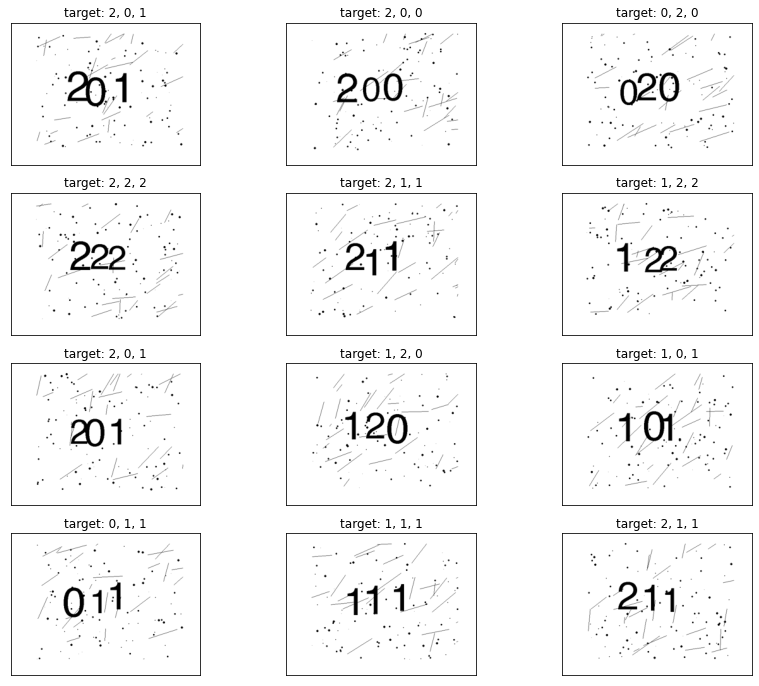

In [42]:
#Show random samples from the dataset
fig, axes = plt.subplots(4, 3, True, True, figsize = (14,12))
random.seed(42)
for i, ax in enumerate(axes.flatten()):
  im_index = random.randint(0, len(X))
  target = ', '.join([str(x) for x in Y[im_index]])
  ax.imshow(X[im_index], cmap = 'gray')
  ax.set_xticks([]), ax.set_yticks([])  # to hide tick values on X and Y axis
  ax.set_title(f"target: {target}")
plt.show()

In [43]:
print(f"Unique labels in dataset: {sum([1 for x in set([target for targets in Y for target in targets])])}")

Unique labels in dataset: 3


# Construct preprocess pipeline

## Cleanup Pipeline

### Cleanup pipeline for 1 image

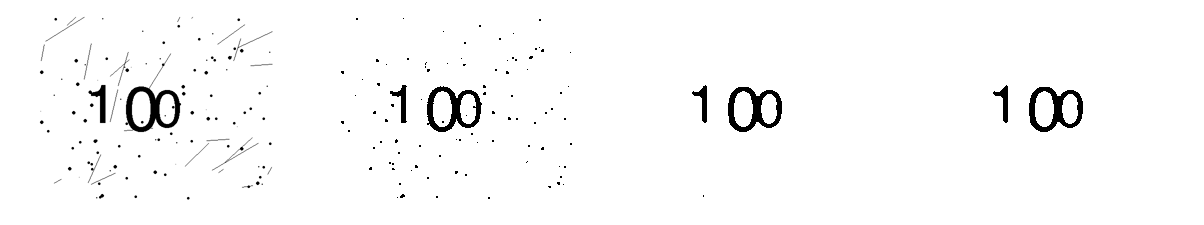

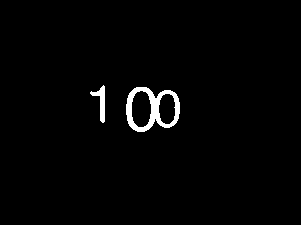

In [44]:
im = X[500].copy()
binary = cv2.threshold(im, 127, 255, cv2.THRESH_BINARY)[1]
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
# Use median filter to remove much of the background noise
median = cv2.medianBlur(binary, 5)
dilated = cv2.dilate(median, kernel, iterations=1)
# Erode to close any gaps in numbers
eroded = cv2.erode(dilated, kernel, iterations=1)
# Subtract the background from the original and invert img
new = cv2.subtract(~binary, eroded)
compare = np.concatenate((im, binary, median, eroded), axis=1)
cv2_imshow(compare)
cv2_imshow(new)

### Cleanup pipeline test on multiple images

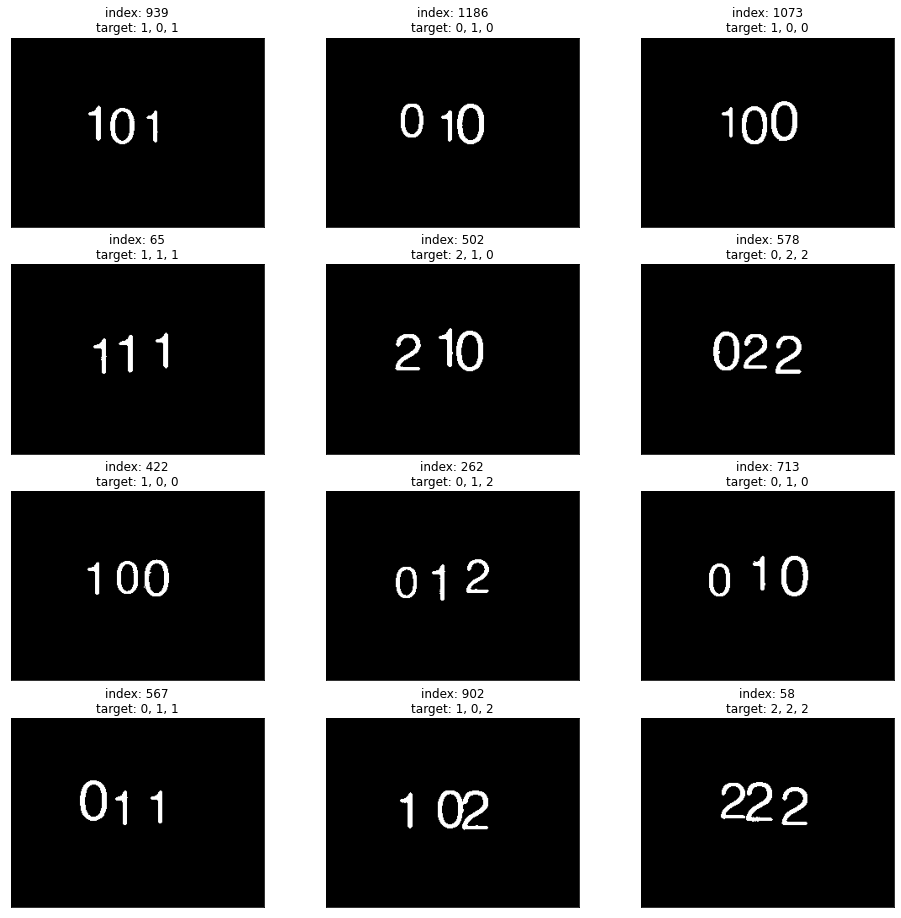

In [45]:
pre_X = []
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))

for i, im in enumerate(X):
  cp = im.copy()
  bin = cv2.threshold(cp, 127, 255, cv2.THRESH_BINARY)[1]
  median = cv2.medianBlur(bin, 5)
  dilated = cv2.dilate(median, kernel, iterations=1)
  eroded = cv2.erode(dilated, kernel, iterations=1)
  cp = cv2.subtract(~bin, eroded)
  pre_X.append(cp)

random.seed(40)
fig, axes = plt.subplots(4, 3, True, True, figsize = (16,16))
for i, ax in enumerate(axes.flatten()):
  im_index = random.randint(0, len(pre_X))#i * 100
  target = ', '.join([str(x) for x in Y[im_index]])
  ax.imshow(pre_X[im_index], cmap = 'gray')
  ax.set_xticks([]), ax.set_yticks([])  # to hide tick values on X and Y axis
  ax.set_title(f"index: {im_index}\ntarget: {target}")
plt.show()

## Extract individual numbers

In [46]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
import random
from operator import itemgetter
import os
import shutil
import time
times = []

#Preprocess training data

class Image():
  def __init__(self, img, name, targets):
    self.matrix = img
    self.name = name
    self.targets = targets


def image_generator(paths):
  for path in paths:
    yield cv2.imread(path, 0)

def get_contours(img):
  '''
  Description: Get all contours
  '''
  contours = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  return contours[0] if len(contours) == 2 else contours[1]


def find_largest_bounding_box(bbs: []) -> ():
  '''
  Description: Return the largest bounding box and its index
  '''
  max_i = 0
  largest_bb = bbs[0]
  for i, bb in enumerate(bbs[1:]):
    # bb[2] = width, bb[3] = height
    if bb[2] * bb[3] > largest_bb[2]*largest_bb[3]:
      max_i = i + 1
      largest_bb = bb
  return max_i, largest_bb


def split_bounding_box_in_parts(img: np.ndarray, bb: (), n: int) -> (int, int):
  '''
  Calculate the new y, w, h for a split bounding box 
  '''
  new_bbs = []
  x, y, w, h = bb
  w_new = w//n

  for i in range(n):
    mask = np.zeros( (img.shape[0], img.shape[1]), dtype=np.uint8)
    x_new = x + w_new * i

    # Mask out everything except the ROI  
    mask[ y : y + h, x_new : x_new + w_new ] = img[y : y + h, x_new : x_new + w_new ]

    #Get the bbs, this can result in multiple bbs since a number might 
    #be split at the wrong place, resulting in multiple fragments 
    temp_bbs = get_bounding_boxes(mask, filter=False)

    #If we only get 1 bb, return it
    if len(temp_bbs) == 1:
      new_bbs.append(temp_bbs[0])
    else:
      #From all bbs, we want to extract the lowest y (starting point, y_new)
      # And h_new = max y + corresponding h - y_start
      y_new = np.inf
      y_end = np.float('-inf')
      for bb in temp_bbs:
        y_new = bb[1] if bb[1] < y_new else y_new
        y_end = bb[1] + bb[3] if bb[1] + bb[3] > y_end else y_end
      
      new_bbs.append((x_new, y_new, w_new, y_end - y_new))
  return new_bbs

def split_largest_bounding_box(bbs: [], img: np.ndarray) -> []:
  '''
  Split the largest bounding box and append new boxes to list
  '''
  i, bb_largest = find_largest_bounding_box(bbs)
  new_bbs = split_bounding_box_in_parts(img, bb_largest, 2)
  del bbs[i]
  bbs.extend(new_bbs)
  return bbs


def get_bounding_boxes(img: np.ndarray, filter: bool = True) -> []:
  contours = get_contours(img)
  if filter:
    return filter_bounding_boxes(contours)
  return [cv2.boundingRect(cntr) for cntr in contours]


def filter_bounding_boxes(contours: []) -> []:
  # Convert contours into bounding boxes and filter out small bb's
  return [cv2.boundingRect(cntr) for cntr in contours if cv2.boundingRect(cntr)[2] > 7 and cv2.boundingRect(cntr)[3] > 7]


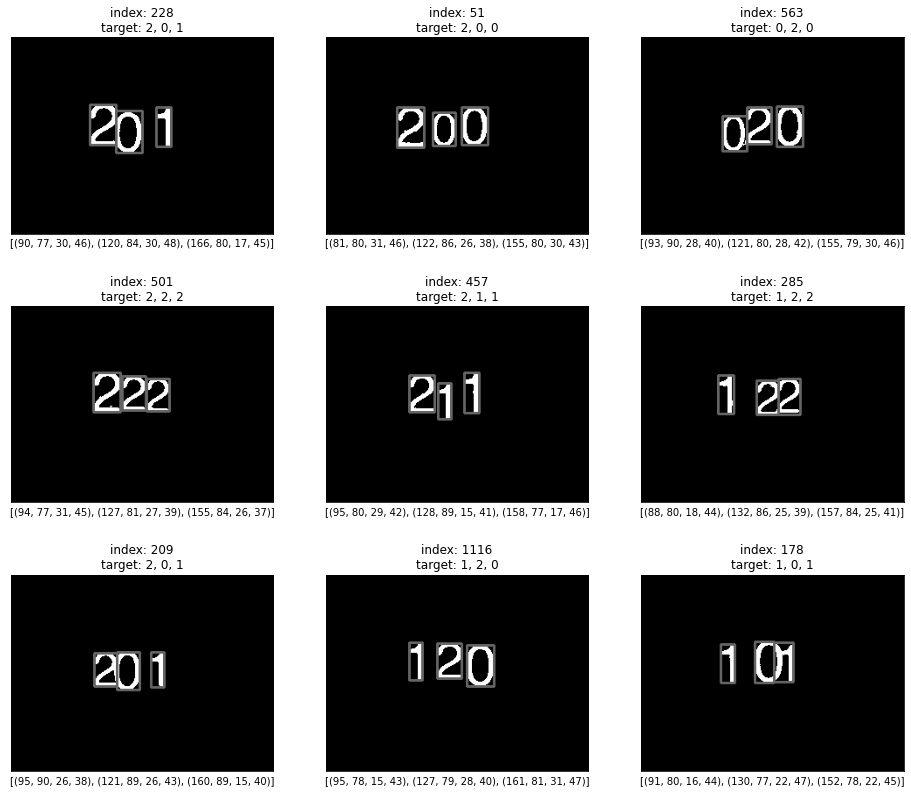

In [47]:
random.seed(42)

fig, axes = plt.subplots(3, 3, True, True, figsize = (16,14))

for i, ax in enumerate(axes.flatten()):
  im_index = random.randint(0, len(pre_X))
  target = ', '.join([str(x) for x in Y[im_index]])

  im = pre_X[im_index].copy()
  bounding_boxes = get_bounding_boxes(im)
  if len(bounding_boxes) == 1:
    bounding_boxes = split_bounding_box_in_parts(img, bounding_boxes[0], 3)
  elif len(bounding_boxes) == 2:
    bounding_boxes = split_largest_bounding_box(bounding_boxes, im)
  bounding_boxes = sorted(bounding_boxes, key=itemgetter(0))
  for box in bounding_boxes:
    x,y,w,h = box
    cv2.rectangle(im, (x, y), (x+w, y+h), (100, 100, 0), 2)
  ax.imshow(im, cmap = 'gray')
  ax.set_xticks([]), ax.set_yticks([])  # to hide tick values on X and Y axis
  ax.set_title(f"index: {im_index}\ntarget: {target}")
  ax.set_xlabel(bounding_boxes)
plt.show()


# Preprocess training data & create dataset folders

In [48]:
import matplotlib.pyplot as plt
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
import pandas as pd
import glob
import random
from operator import itemgetter
import os
import shutil
import time
times = []

#Preprocess training data

class Image():
  def __init__(self, img, name, targets):
    self.matrix = img
    self.name = name
    self.targets = targets


def image_generator(paths):
  for path in paths:
    yield cv2.imread(path, 0)

def get_contours(img):
  '''
  Description: Get all contours
  '''
  contours = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  return contours[0] if len(contours) == 2 else contours[1]


def find_largest_bounding_box(bbs: []) -> ():
  '''
  Description: Return the largest bounding box and its index
  '''
  max_i = 0
  largest_bb = bbs[0]
  for i, bb in enumerate(bbs[1:]):
    # bb[2] = width, bb[3] = height
    if bb[2] * bb[3] > largest_bb[2]*largest_bb[3]:
      max_i = i + 1
      largest_bb = bb
  return max_i, largest_bb


def split_bounding_box_in_parts(img: np.ndarray, bb: (), n: int) -> (int, int):
  '''
  Calculate the new y, w, h for a split bounding box 
  '''
  new_bbs = []
  x, y, w, h = bb
  w_new = w//n

  for i in range(n):
    mask = np.zeros( (img.shape[0], img.shape[1]), dtype=np.uint8)
    x_new = x + w_new * i

    # Mask out everything except the ROI  
    mask[ y : y + h, x_new : x_new + w_new ] = img[y : y + h, x_new : x_new + w_new ]

    #Get the bbs, this can result in multiple bbs since a number might 
    #be split at the wrong place, resulting in multiple fragments 
    temp_bbs = get_bounding_boxes(mask, filter=False)

    #If we only get 1 bb, return it
    if len(temp_bbs) == 1:
      new_bbs.append(temp_bbs[0])
    else:
      #From all bbs, we want to extract the lowest y (starting point, y_new)
      # And h_new = max y + corresponding h - y_start
      y_new = np.inf
      y_end = np.float('-inf')
      for bb in temp_bbs:
        y_new = bb[1] if bb[1] < y_new else y_new
        y_end = bb[1] + bb[3] if bb[1] + bb[3] > y_end else y_end
      
      new_bbs.append((x_new, y_new, w_new, y_end - y_new))
  return new_bbs

def split_largest_bounding_box(bbs: [], img: np.ndarray) -> []:
  '''
  Split the largest bounding box and append new boxes to list
  '''
  i, bb_largest = find_largest_bounding_box(bbs)
  new_bbs = split_bounding_box_in_parts(img, bb_largest, 2)
  del bbs[i]
  bbs.extend(new_bbs)
  return bbs


def get_bounding_boxes(img: np.ndarray, filter: bool = True) -> []:
  contours = get_contours(img)
  if filter:
    return filter_bounding_boxes(contours)
  return [cv2.boundingRect(cntr) for cntr in contours]


def filter_bounding_boxes(contours: []) -> []:
  # Convert contours into bounding boxes and filter out small bb's
  return [cv2.boundingRect(cntr) for cntr in contours if cv2.boundingRect(cntr)[2] > 7 and cv2.boundingRect(cntr)[3] > 7]


In [49]:
start = time.time()


# Load training data for preprocess
img_paths = glob.glob("./train/*.png")
img_paths.sort()
img_names = [os.path.basename(x).split('.')[0] for x in img_paths]
img_gen = image_generator(img_paths)

#Load targets
Y = pd.read_csv(TRAINING_LABELS_PATH, sep=", ", header = None, engine = 'python' ).values.tolist()

imgs = []
for img, name, targets in zip(img_gen, img_names, Y):
  imgs.append(Image(img, name, targets))

#Preprocess all training data
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
for im in imgs:
  cp = im.matrix.copy()
  bin = cv2.threshold(cp, 127, 255, cv2.THRESH_BINARY)[1]
  median = cv2.medianBlur(bin, 5)
  dilated = cv2.dilate(median, kernel, iterations=1)
  eroded = cv2.erode(dilated, kernel, iterations=1)
  cp = cv2.subtract(~bin, eroded)
  im.matrix = cp


#Save training data in appropriate directories

root_path = './dataset'

#Create directories
try:
  os.makedirs(root_path)
  print("Created dataset folder")
except FileExistsError:
  print("Directory already exists, continuing")

labels = set([target for targets in Y for target in targets])

for label in labels:
  try:
    os.mkdir(f"{root_path}/{label}")
    print(f"Created directory for class {label}")
  except FileExistsError:
    print(f"Directory for class {label} already exists, continuing")

#Save the images
for img in imgs:
  bounding_boxes = get_bounding_boxes(img.matrix)
  if len(bounding_boxes) == 1:
    bounding_boxes = split_bounding_box_in_parts(img.matrix, bounding_boxes[0], 3)
  elif len(bounding_boxes) == 2:
    bounding_boxes = split_largest_bounding_box(bounding_boxes, img.matrix)
  bounding_boxes = sorted(bounding_boxes, key=itemgetter(0))
  
  for j, (box, target) in enumerate(zip(bounding_boxes, img.targets)):
    x,y,w,h = box
    cv2.imwrite(f"{root_path}/{target}/{img.name}_{j}.png", img.matrix[y:y+h, x:x+w])

times.append(time.time() - start)

Directory already exists, continuing
Directory for class 0 already exists, continuing
Directory for class 1 already exists, continuing
Directory for class 2 already exists, continuing


# Neural Net construction & training

In [50]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Subset, DataLoader, SubsetRandomSampler, Dataset
import torchvision as tv
from torchvision.datasets import ImageFolder
from torchvision.datasets.folder import default_loader
from torchvision import transforms
from sklearn.model_selection import train_test_split, KFold

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [51]:
class CaptchaData(ImageFolder):
  def __init__(self, root, loader=default_loader, is_valid_file=None):
    super(CaptchaData, self).__init__(root=root, loader=loader, is_valid_file=is_valid_file)

  def __getitem__(self, index):
    image_path, target = self.samples[index]
    im = cv2.imread(image_path, 0)
    #im = cv2.threshold(im, 127, 255, cv2.THRESH_BINARY)[1]
    im = cv2.resize(im, (28, 28), interpolation = cv2.INTER_AREA)
    sample = transforms.ToTensor()(im)
    return sample, target
  
  def __len__(self):
    return len(self.samples)

In [52]:
class CaptchaClassifier(nn.Module):
  def __init__(self):
    super(CaptchaClassifier, self).__init__()

    self.layer1 = nn.Sequential(
        nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=2),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2))
    
    self.layer2 = nn.Sequential(
        nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=2),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2))
    
    self.flatten = nn.Flatten()
    self.drop_out = nn.Dropout(0.5)
    self.fc1 = nn.Linear(8 * 8 * 64, 1000)
    self.fc2 = nn.Linear(1000, 200)
    self.fc3 = nn.Linear(200, 3)
  

  def forward(self, x):
    out = self.layer1(x)
    out = self.layer2(out)
    out = self.flatten(out)
    out = self.drop_out(out)
    out = self.fc1(out)
    out = self.drop_out(out)
    out = self.fc2(out)
    out = self.drop_out(out)
    out = self.fc3(out)
    return out


def adaptive_learning_rate(g_min, g_max, it):
  return g_min + (g_max - g_min) * np.exp(-it/312)


def train_test_dataset(dataset, test_split=0.05):
  train_idx, test_idx = train_test_split(list(range(len(dataset))), test_size=test_split)
  datasets = {}
  datasets['train'] = Subset(dataset, train_idx)
  datasets['test'] = Subset(dataset, test_idx)
  return datasets



In [53]:
dataset = CaptchaData(root_path)

# Split dataset into XY_train and XY_test
datasets = train_test_dataset(dataset)
batch_size = 100
test_loader = DataLoader(datasets['test'], batch_size, shuffle=True, num_workers=4)
train_loader = DataLoader(datasets['train'], batch_size, shuffle=True, num_workers=4)


In [31]:
# Train the model
train_loss_list = []
train_acc_list = []
train_iter = []
test_acc_list = []
test_loss_list = []
test_iter = []

num_epochs = 5

gamma_max = 0.003
gamma_min = 0.0001

# Loss criterion
criterion = nn.CrossEntropyLoss()

model = CaptchaClassifier()
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=adaptive_learning_rate(gamma_min, gamma_max, 0))

t = 0

start = time.time()

for epoch in range(num_epochs):
  for images, labels in train_loader:
    model.train()
    
    # Apply adaptive lr
    for p in optimizer.param_groups:
      p['lr'] = adaptive_learning_rate(gamma_min, gamma_max, t)

    #Load data onto GPU (if active)
    images, labels = images.to(device), labels.to(device)

    #Reset optimizer gradients
    optimizer.zero_grad()

    # Run the forward pass
    outputs = model(images)
    loss = criterion(outputs, labels)

    # Backprop and perform Adam optimisation
    loss.backward()
    optimizer.step()

    with torch.no_grad():
      model.eval()
      # evaluate the performance on the training data at every 10th iteration
      if t % 5 == 0:
        train_loss_list.append(loss.item())
        total = labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        train_acc_list.append(correct / total)
        train_iter.append(t)
        
        if t % 10 == 0:
          for test_images, test_labels in test_loader:
            test_images, test_labels = test_images.to(device), test_labels.to(device)

            # compute predictions for the test data
            test_outputs = model(test_images)
            loss = criterion(test_outputs, test_labels)
            test_loss_list.append(loss.item())
            total = test_labels.size(0)
            _, predicted = torch.max(test_outputs.data, 1)
            correct = (predicted == test_labels).sum().item()
            test_acc_list.append(correct/total)
            test_iter.append(t)
    if t % 10 == 0:
      print(f"Step {t:5d}: train accuracy {100 * train_acc_list[-1]:6.2f}% " \
      f"train cross-entropy {train_loss_list[-1]:5.2f}  " \
      f"val accuracy {100 * test_acc_list[-1]:6.2f}% " \
      f"val cross-entropy {test_loss_list[-1]:5.2f}")

    t += 1
  # print the iteration number and the accuracy of the predictions
  print(f"Epoch: {epoch + 1}/{num_epochs} " \
        f"Step {t:5d}: train accuracy {100 * train_acc_list[-1]:6.2f}% " \
        f"train cross-entropy {train_loss_list[-1]:5.2f}  " \
        f"val accuracy {100 * test_acc_list[-1]:6.2f}% " \
        f"val cross-entropy {test_loss_list[-1]:5.2f}\n")

times.append(time.time() - start)

Step     0: train accuracy  35.00% train cross-entropy  1.11  val accuracy  68.75% val cross-entropy  0.65
Step    10: train accuracy 100.00% train cross-entropy  0.01  val accuracy 100.00% val cross-entropy  0.00
Step    20: train accuracy 100.00% train cross-entropy  0.00  val accuracy 100.00% val cross-entropy  0.00
Step    30: train accuracy 100.00% train cross-entropy  0.00  val accuracy 100.00% val cross-entropy  0.00
Epoch: 1/5 Step    35: train accuracy 100.00% train cross-entropy  0.00  val accuracy 100.00% val cross-entropy  0.00

Step    40: train accuracy 100.00% train cross-entropy  0.00  val accuracy 100.00% val cross-entropy  0.00
Step    50: train accuracy  99.00% train cross-entropy  0.04  val accuracy 100.00% val cross-entropy  0.00
Step    60: train accuracy 100.00% train cross-entropy  0.00  val accuracy 100.00% val cross-entropy  0.00
Epoch: 2/5 Step    70: train accuracy 100.00% train cross-entropy  0.00  val accuracy 100.00% val cross-entropy  0.00

Step    70: t

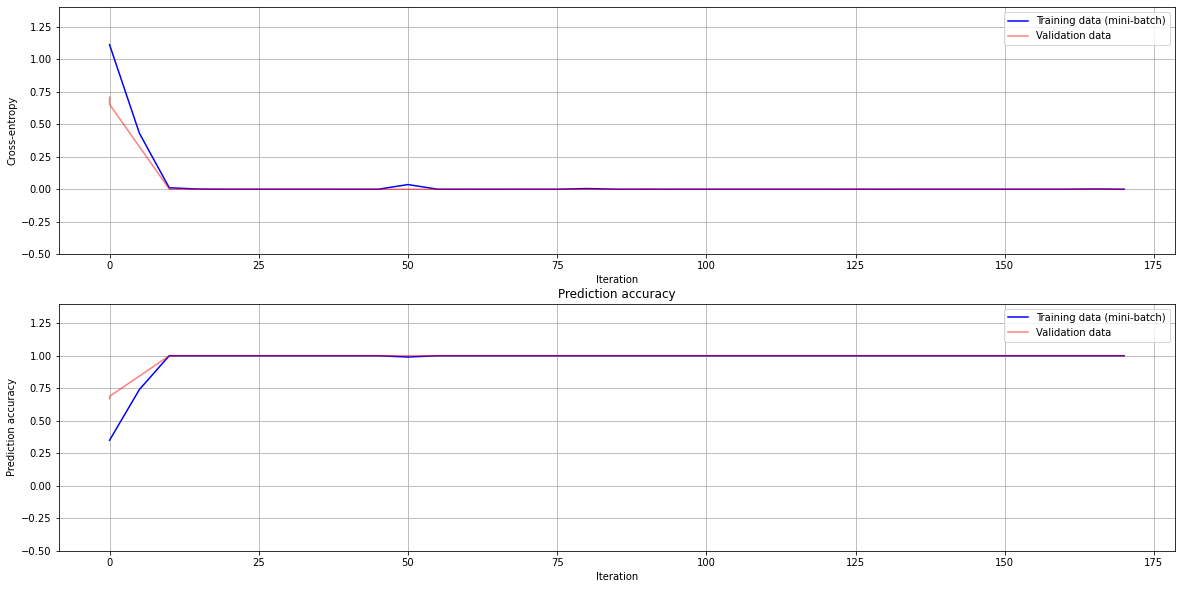

In [32]:
fig, axes = plt.subplots(2, 1, figsize=(20, 10), sharey=True)

for i, (ax1, ax2) in enumerate( zip(axes.flatten()[: len(axes.flatten())//2 ], axes.flatten()[ len(axes.flatten())//2 : ])):
  # plot the cross-entropy
  ax1.plot(train_iter, train_loss_list, 'b-', label='Training data (mini-batch)')
  ax1.plot(test_iter, test_loss_list, 'r-', alpha=0.5, label='Validation data')
  ax1.set_xlabel('Iteration')
  ax1.set_ylabel('Cross-entropy')
  ax1.set_ylim([0, max(test_loss_list) * 1.1 ])
  ax1.grid(True)
  ax1.legend(loc='best')

  # plot the accuracy
  ax2.plot(train_iter, train_acc_list, 'b-', label='Training data (mini-batch)')
  ax2.plot(test_iter, test_acc_list, 'r-', alpha=0.5, label='Validation data')
  ax2.set_xlabel('Iteration')
  ax2.set_ylabel('Prediction accuracy')
  ax2.set_ylim([-0.5, 1.4])
  ax2.set_title('Prediction accuracy')
  ax2.grid(True)
  ax2.legend(loc='best')

fig.show()

In [33]:
# Test the model
model.eval()
with torch.no_grad():
  correct = 0
  total = 0
  for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
  print(f'Test Accuracy of the model on the {total} test images: {((correct / total) * 100)}% \n({correct} out of {total})')

Test Accuracy of the model on the 180 test images: 100.0% 
(180 out of 180)


# Classify unseen data

In [34]:
from torchvision.utils import make_grid

In [35]:
def show(data):
  digits, og = data
  fig = plt.figure(figsize=(6, 6))
  grid = plt.GridSpec(2, len(digits), hspace=0.1, wspace=0.1)
  og_ax = fig.add_subplot(grid[0, :], xticklabels=[], yticklabels=[])
  og_ax.set_title('Original image')
  og_ax.imshow(og[0], cmap="gray")

  for i in range(len(digits)):
    num = fig.add_subplot(grid[1, i], xticklabels=[], yticklabels=[])
    num.set_title(f'Digit {i + 1}')
    num.imshow(digits[i][0], cmap="gray")
  plt.show()


def yield_line(filepath):
  with open(filepath, 'r') as f:
    for line in f:
      yield line

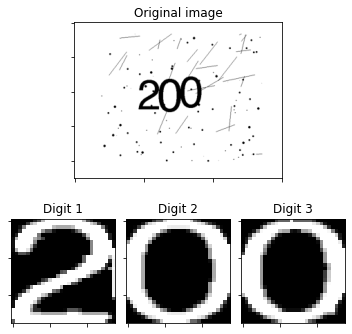

In [36]:
class NewImagesData(Dataset):
  def __init__(self, root, loader = default_loader, is_valid_file=None):
    img_paths = glob.glob(f"{root}/*")
    img_paths.sort()
    self.img_paths = img_paths
  
  def __len__(self):
    return len(self.img_paths)

  def __getitem__(self, index):
    image_path = self.img_paths[index]
    im = cv2.imread(image_path, 0)
    
    extracted_nums = []
    cp = im.copy()
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
    bin = cv2.threshold(cp, 127, 255, cv2.THRESH_BINARY)[1]
    median = cv2.medianBlur(bin, 5)
    dilated = cv2.dilate(median, kernel, iterations=1)
    eroded = cv2.erode(dilated, kernel, iterations=1)
    cp = cv2.subtract(~bin, eroded)
    bounding_boxes = get_bounding_boxes(cp)

    if len(bounding_boxes) == 1:
      bounding_boxes = split_bounding_box_in_parts(cp, bounding_boxes[0], 3)
    
    elif len(bounding_boxes) == 2:
      bounding_boxes = split_largest_bounding_box(bounding_boxes, cp)
    
    bounding_boxes = sorted(bounding_boxes, key=itemgetter(0))
    
    for box in bounding_boxes:
      x,y,w,h = box
      extracted_num = cp[y:y+h, x:x+w]
      extracted_num = cv2.resize(extracted_num, (28, 28), interpolation = cv2.INTER_AREA)
      extracted_num = transforms.ToTensor()(extracted_num)
      extracted_nums.append(extracted_num)
    
    return extracted_nums, transforms.ToTensor()(im)


data_to_predict = NewImagesData('./real')
predict_loader = DataLoader(data_to_predict, 1, False)

show(data_to_predict[164])



In [37]:
start = time.time()

model.eval()
with open('./predictions.txt', 'w') as fi:
  for i, (digits, __) in enumerate(predict_loader):
    predictions = []
    for digit in digits:
      digit = digit.to(device)
      with torch.no_grad():
        outputs = model(digit)
        _, predicted = torch.max(outputs.data, 1)
        predictions.append(predicted.item())
    #print(f"{i}: {predictions}")
    fi.write(', '.join([str(x) for x in predictions]) + '\n')

times.append(time.time() - start)

In [38]:
try:
  correct = total = 0
  predictions = yield_line('./predictions.txt')
  solutions = yield_line(SOLUTION_LABELS_PATH)
  for pred, sol in zip(predictions, solutions):
    total += 1
    if pred == sol:
      correct += 1

  print(f"Predicted a total of {total} images.\n{correct}, i.e. {correct / total * 100 :3.5f}% classified correctly.")

except:
  print("The path for solution labels is not properly defined. \n")

print("Predictions can be found in './predictions.txt' in the Sidebar > Files for manual validation.\n")
print(f"Preprocessing time: {times[0]:2.3f}s \n" \
      f"Training time: {times[1]:2.3f}s \n" \
      f"Prediction time: {times[2]:2.3f}s \n" \
      f"Total time: {sum(times):2.3f}s")
  

Predicted a total of 1200 images.
1200, i.e. 100.00000% classified correctly.
Predictions can be found in './predictions.txt' in the Sidebar > Files for manual validation.

Preprocessing time: 1.680s 
Training time: 8.191s 
Prediction time: 4.334s 
Total time: 14.205s
